# Не шуми!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import scipy.io
from scipy.optimize import minimize
from scipy.optimize import check_grad
import pandas as pd

### Функция, удаляющая шумы  
#### Принимает:
xcor - массив точек  
eps - эпсилон, задающий шум
#### Возвращает:
Новый массив без шумов
#### Примечание:
работает в предположении о том, что xcor - list

In [2]:
def delnoize(xcor, eps):
    bcount = math.ceil(0.008*len(xcor))
    i = 1
    lst = []
    while i < len(xcor):
        
        norm = xcor[i-1]
        noize = False
        
        if abs(xcor[i] - norm) > eps:
            j = 0
            noize = False
            while j < bcount:
                if abs(xcor[i+j] - norm) < eps:
                    noize = True
                    break
                j = j + 1
                
        if noize:
            lst.append([i, i+j-1])
            i = i + j
        else:
            i = i + 1
            
    i = len(lst) - 1

    while i >= 0:
        a = lst[i][0]
        b = lst[i][1]
        for k in range(0, b-a+1):
            xcor.pop(a)
        i = i - 1
        
    return xcor

### Функция, обнаруживающая разрывы  
#### Принимает:
Параметры аналогичны предыдущей функции  
#### Возвращает:
Возвращает список разрывов
#### Примечание:
Работает в предположении об отсутсвии шумов

In [3]:
def foundgap(xcor, eps): 
    i = 1
    lst = []
    while i < len(xcor):
        norm = xcor[i-1]
        if abs(xcor[i] - norm) > eps:
            lst.append(i-1)
        i = i + 1
    return lst  

### Генератор сигналов для проверки масштабируемости  
#### Принимает:
eps - максимальная разница между соседними точками вне шумов (10 * eps - размер шумов)  
N - количество точек  
section_list - отрезки, на которых определены функции  
f_list - собственно сами функции   
#### Возвращает:
Возвращает сигнал - массив точек

In [201]:
def advanced_generator(N, section_list, f_list,  eps):
    points = []
    
    for i in range(len(section_list)):
        section_start = int(section_list[i][0]) 
        section_end = int(section_list[i][1])
        for j in range(section_start, section_end):
            points.append(f_list[i](j) + random.uniform(0, eps))
    
    noises_indexes = sorted([random.randrange(0, N) for i in range(0, 6)])
    for i in noises_indexes:
        noises_num = random.randrange(5, 30)
        direction = random.randrange(-1, 2)
        step_size = random.uniform(4 * eps, 10 * eps)
        for j in range(0, noises_num):
            points[i + j] += direction * step_size
    return points

### Пример использования приведенных выше функций

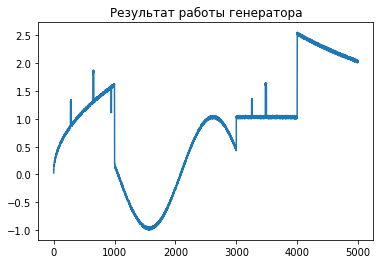

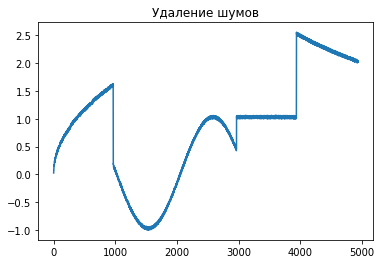

Координаты разрывов после удаления шумов: [965, 2965, 3936]


In [247]:
N = 5000
section_list_gen = [[0, 1000], 
                [1000, 3000], 
                [3000, 4000], 
                [4000, 5000]]
f_list = [lambda x: 0.05*x**0.5,
          lambda x: np.sin(0.003 * x), 
          lambda x: 1,
          lambda x: 10000/x]
eps_fluct = 0.06
eps = 0.2

y_gen = advanced_generator(N, section_list_gen, f_list, eps_fluct)
plt.plot(y_gen)
plt.title("Результат работы генератора")
plt.show()
y_gen = delnoize(y_gen, eps)
lst = foundgap(y_gen, eps)
plt.plot(y_gen)
plt.title("Удаление шумов")
plt.show()
print("Координаты разрывов после удаления шумов: ", lst, sep = "")

### Перед тем как пользоваться методами

#### Выгружаем данные

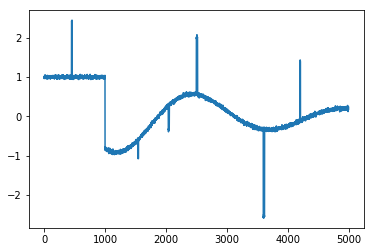

In [205]:
data = scipy.io.loadmat('denoising_data.mat')
y_raw = data['xcor']
x_raw = np.arange(1, y_raw.shape[0] + 1)
plt.plot(x_raw, y_raw)
plt.show()

#### Очищаем от шумов и ищем отрезки непрерывности

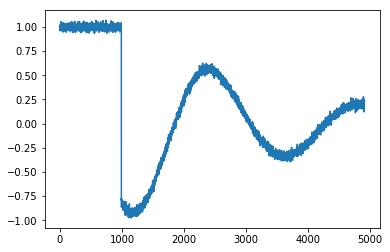

Участки непрерывности [[0, 988], [988, 4910]]


In [248]:
eps = 0.2
def cleanAndSectionSearch(eps, y_raw):
    
    y_raw_list = [y_raw[i][0] for i in range(y_raw.shape[0])]
    y_clean_list = delnoize(y_raw_list, eps)

    y = np.asarray([[item] for item in y_clean_list])
    N = y.shape[0] + 1
    x = np.arange(1, N)

    gaps = [0]
    gaps.extend(foundgap(y_clean_list, eps))
    gaps.append(N)
    section_list = [[gaps[i], gaps[i+1]] for i in range(len(gaps)-1)]
    return y, x, section_list

y, x, section_list = cleanAndSectionSearch(eps, y_raw)
plt.plot(x, y)
plt.show()
print("Участки непрерывности", section_list)

## Явное решение:

#### Создаем матрицу признаков 

In [249]:
df = pd.DataFrame()
df['x'] = x / 5000
features = {'const':lambda x: 1, 'x': lambda x: x, 'x^2': lambda x: x**2, 'x^3': lambda x: x**3, 'x^4': lambda x: x**4, 
            'x^5': lambda x: x**5, 'x^6': lambda x: x**6, 'x^7': lambda x: x**7, 'x^8': lambda x: x**8, 'x^9': lambda x: x**9}
for item in features.items():
    df[item[0]] = df['x'].apply(item[1])
df.head()

,x,const,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9
0,0.0002,1,4.000000e-08,8.000000e-12,1.600000e-15,3.200000e-19,6.400000e-23,1.280000e-26,2.560000e-30,5.120000e-34
1,0.0004,1,1.600000e-07,6.400000e-11,2.560000e-14,1.024000e-17,4.096000e-21,1.638400e-24,6.553600e-28,2.621440e-31
2,0.0006,1,3.600000e-07,2.160000e-10,1.296000e-13,7.776000e-17,4.665600e-20,2.799360e-23,1.679616e-26,1.007770e-29
3,0.0008,1,6.400000e-07,5.120000e-10,4.096000e-13,3.276800e-16,2.621440e-19,2.097152e-22,1.677722e-25,1.342177e-28
4,0.0010,1,1.000000e-06,1.000000e-09,1.000000e-12,1.000000e-15,1.000000e-18,1.000000e-21,1.000000e-24,1.000000e-27


#### На каждом участке приравниваем градиент среднеквадратичной ошибки к нулю и находим явное решение

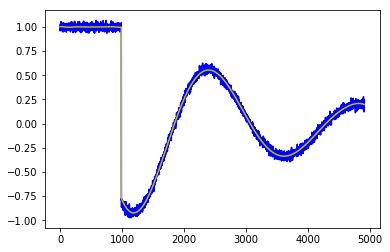

In [250]:
F = df.values
F_gen = df_gen.values

def explicitSolver(y, section_list, F):
    final = []
    for i in range(len(section_list)):
        y_curr = y[section_list[i][0]: section_list[i][1]]
        F_curr = F[section_list[i][0]: section_list[i][1]]
        FtF_inv = np.linalg.inv(F_curr.T.dot(F_curr))
        w = FtF_inv.dot(F_curr.T).dot(y_curr)
        y_pred = F_curr[:,:].dot(w)
        final.append(y_pred)
    final = np.concatenate(final)
    return final

result = explicitSolver(y, section_list, F)
plt.plot(y, 'b')
plt.plot(result, 'y')
plt.show()

## Метод градиентного спуска:

### Введем функцию ошибки и ее градиент

In [251]:
def Q(y, F, w):
    Y = y.reshape(-1,)
    return np.sum((np.dot(F, w) - Y)**2)

def gradQ(y, F, w):
    Y = y.reshape(-1,)
    return np.dot(F.T, np.dot(F, w) - Y) / Y.shape[0]

### Сам метод

In [252]:
def GC(F, y, eta, eps, max_iter):
    loss = []
    w = np.zeros(len(features))
    for i in range(max_iter):
        grad = gradQ(y, F, w)
        if (np.linalg.norm(grad) < eps):
            break
        w -= eta * gradQ(y, F, w)
        loss.append(Q(y, F, w))
    return loss, w

#### Тестируем

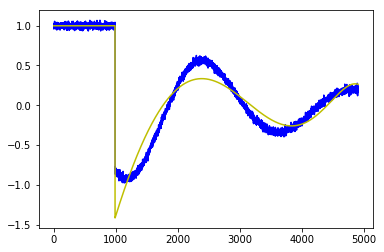

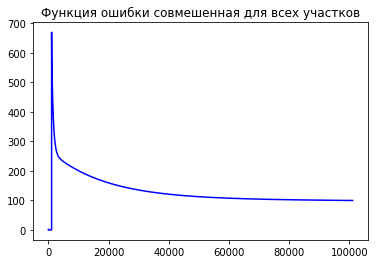

In [42]:
final = []
final_loss = []
eta = 0.95
eps = 1e-5
max_iter = 100000

for i in range(len(section_list)):
    y_curr = y[section_list[i][0]: section_list[i][1]]
    F_curr = F[section_list[i][0]: section_list[i][1]]
    loss, w = GC(F_curr, y_curr, eta, eps, max_iter)
    y_pred = F_curr[:,:].dot(w)
    final.append(y_pred)
    final_loss.append(loss)

final = np.concatenate(final)
final_loss = np.concatenate(final_loss)

plt.plot(x, y, 'b')
plt.plot(x, final, 'y')
plt.show()

plt.plot(final_loss, 'b')
plt.title("Функция ошибки совмешенная для всех участков")
plt.show()

## Апроксимация при помощи minimize:

Optimization terminated successfully.
         Current function value: 0.552084
         Iterations: 22
         Function evaluations: 44
err:  [0.0695411]
degree of polinom:  0
Optimization terminated successfully.
         Current function value: 670.212274
         Iterations: 15
         Function evaluations: 30
err:  [0.90188325]
Optimization terminated successfully.
         Current function value: 587.828574
         Iterations: 48
         Function evaluations: 90
err:  [0.78315238]
Optimization terminated successfully.
         Current function value: 449.118196
         Iterations: 113
         Function evaluations: 208
err:  [0.64214488]
Optimization terminated successfully.
         Current function value: 142.622208
         Iterations: 241
         Function evaluations: 417
err:  [0.70670884]
Optimization terminated successfully.
         Current function value: 176.942108
         Iterations: 201
         Function evaluations: 361
err:  [0.66317658]
Optimization terminat

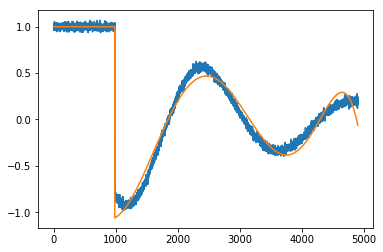

In [40]:
eps = 0.5
def mkPol(coff, x):
    pol = 0
    for dgr in range(0,len(coff)):
        pol += coff[dgr]*(x**dgr)
    return pol
def funcToMin(coff, tup):
    res = 0
    for i in range(tup[1],tup[2]):
        pol = mkPol(coff, i)
        res += (tup[0][i]-pol)**2
    return res
def polyGain(y, lst, eps):
    xcor = []
    for i in range(0, len(y)): xcor.append(y[i])
    arr = []
    for k in range(0, len(lst)):
        left = lst[k][0] + 1
        right = lst[k][1] - 1
        err = 2*eps
        j = 1
        while err > eps:
            x0 = [0]*(j)
            res = minimize(funcToMin, x0, args = [xcor, left, right], method='Nelder-Mead', options={'xtol': 1e-2, 'disp': True})
            narr = []
            err = 0
            for i in range(left, right):
                nval = mkPol(res.x, i)
                if abs(nval-xcor[i]) > err: err = abs(nval-xcor[i])
                narr.append(nval)
            j += 1
            print("err: ", err)
        print("degree of polinom: ", len(res.x) - 1)
        arr += narr
    return arr
final = polyGain(y, section_list, eps)
plt.plot(y)
plt.plot(final)
plt.show()